<a href="https://colab.research.google.com/github/koffi09/BigDatas/blob/master/DEVOIR_MAISON_DEEP_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                        #DEVOIR DE MASION DEEP LEANING 
                        
                        Nom et prénom : N'DRI KOFFI ROLAND

In [1]:
!pip install pillow
!pip install fastai==2.5.3
!pip install fastai2_extes
!pip install matplotlib_venn


     |████████████████████████████████| 189 kB 3.8 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: Could not find a version that satisfies the requirement fastai2_extes (from versions: none)
ERROR: No matching distribution found for fastai2_extes


In [2]:
!pip install fastai2-extensions

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import random

import numpy as np
import pandas as pd

import torch
from fastai.vision.all import *

from PIL import Image

from fastai2_extensions.interpret.all import *
import time

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

**Question 1: Utilisez le “seed number” 2021 dans tout votre travail.**

In [5]:
seed = 2021
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

**Question 2:Chargez les images avec la librairie fastai et en visualisez un lot (batch)**

In [6]:
df = pd.read_csv('/content/drive/MyDrive/DEEP/driver_imgs_list.csv')
display(df.sample(5))


,subject,classname,img
11176,p041,c6,img_6089.jpg
2091,p014,c5,img_11781.jpg
15668,p051,c3,img_244.jpg
9242,p026,c9,img_12588.jpg
10069,p035,c9,img_49391.jpg


In [10]:
def classe(x):
    return (df.loc[df.img==x, "classname"].values[0])

path = "/content/drive/MyDrive/DEEP/train"
dls = ImageDataLoaders.from_name_func(
    path, 
    get_image_files(path), 
    valid_pct=0.25, 
    seed=seed, 
    label_func=classe, 
    item_tfms=Resize(224))

dls.show_batch()

IndexError: ignored

***Question 3:  Déterminez les différentes strates ou aspects de ces images puis construisez un ensemble
de validation équilibré entre ces dernières en vous basant sur les infos de ce dataset
mentionné à la fin du notebook “lesson1_cnn”. Le ratio de l’ensemble de validation doit
être de 25%.***

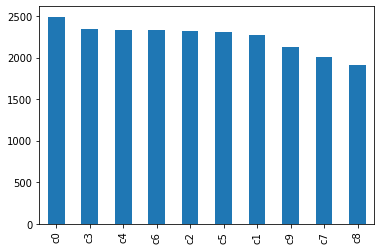

In [11]:
classe = df.classname.value_counts()
fig = classe.plot(kind='bar')

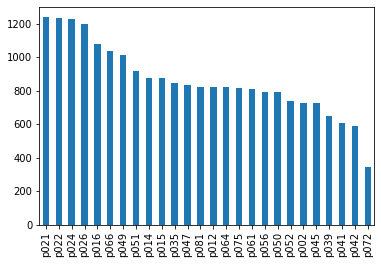

In [12]:
subject = df.subject.value_counts()
fig = subject.plot(kind='bar')

#### Création du jeu de validation

In [13]:
df = df.assign(for_test=False)

# On garde la pourcentage (pourcentage) de sujets par classe
pct = df.assign(nb=1).groupby(['subject', 'classname']).sum()
pct = pct.assign(pct = (pct.nb/df.shape[0]*100))
pct = pct.assign(subject=pct.index.get_level_values('subject'), classname=pct.index.get_level_values('classname'))
pct.index = range(0, pct.shape[0])


# pourcentage de chaque classe dans notre jeu de donnéees
pct_classe = df.classname.value_counts() / df.shape[0] * 100


# on crée un dictionnaire contenant pour chaque classe et pour notre échantillon de test:
#    nb: pourcentage d'individu pour la classe qu'on aura à chaque itération, ,
#    max : correspond à la pourcentage de la classe dans notre jeu de données (dont on ne devra pas trop s'éloigner),
#    subject: sujet sélectionné pour la classe.
dico = dict()
for c in df.classname.unique():
    dico[c] = { 'nb': 0, 'max': pct_classe[c], 'subject': [] }
dico['t'] = { 'nb': 0, 'max': 25, 'subject': [] }


for c in df.classname.unique():
    # Les instruction à l'intérieur de cette boucle permettront de déterminer si le sujet sera pris en test ou pas
    for sub in pct.subject.unique():
        # la condition ci-dessous permet de vérifier pour notre échantillon de test si nous sommes en dessous des 25%,
        # et que pour chaque classe nousavons le pourcentage qui est respecté dans le test.
        if sub not in dico['t']['subject'] and dico['t']['nb'] < 25 and sub not in dico[c]['subject'] and dico[c]['nb'] < dico[c]['max']:
            # cette boucle permet d'ajouter le sujet dans la partie subject de chaque classe vu que le sujet respecte les conditions précédentes
            for c2 in df.classname.unique():
                dico[c2]['subject'].append(sub)
                dico[c2]['nb'] += sum(pct.loc[((pct.subject == sub) & (pct.classname == c2)), 'pct'])
           
            # on ajoute le sujet à la partie sujet de notre partie test
            dico['t']['subject'].append(sub)
            dico['t']['nb'] += sum(pct.loc[pct.subject == sub, 'pct'])


df.loc[df.subject.isin(dico['t']['subject']), 'for_test'] = True

In [14]:
df.loc[:, "path"] = df.loc[:, "classname"].astype("str") + '/' + df.loc[:, "img"].astype("str")

In [17]:
dls = ImageDataLoaders.from_df(
    df,
    '/content/drive/MyDrive/DEEP/', 
    folder='train', 
    valid_col='for_test', 
    fn_col=4, 
    item_tfms=Resize(224),
    label_col=1,
    seed=seed)

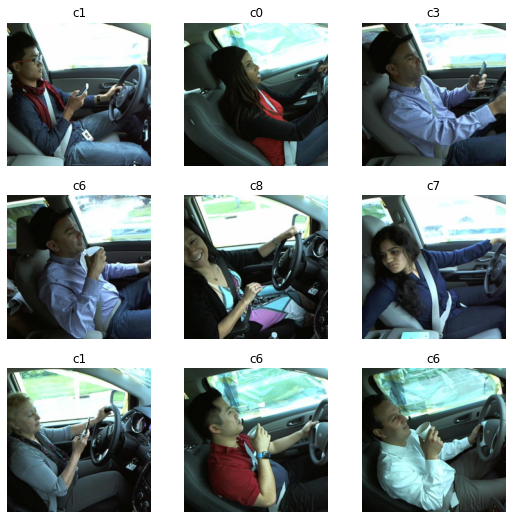

In [18]:
dls.show_batch()

***Question 4. Entraînez votre modèle (apprentissage par transfert) pendant 5 époques en prenant le
soin d’utiliser le rythme d’apprentissage optimal fourni par fastai.***

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

Recherche du meilleur learning rate

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(epochs=5, base_lr=lrs.minimum, cbs=[ShowGraphCallback(),])

In [ ]:
learn.save("./somnolence_model_q4")

***Question 5: Entraînez votre modèle à nouveau jusqu’à la dégradation (forte ameliorementation) du loss de
l’ensemble de validation. Précisez le numéro de l’époque où cette divergence du loss a
débuté et la meilleure performance obtenue.***

In [ ]:
learn2 = cnn_learner(dls, resnet18, metrics=[error_rate])
learn2.fine_tune(epochs=25, base_lr=lrs.minimum, cbs=[ShowGraphCallback(),])

In [ ]:
learn2.save("./somnolence_model_q5")

***(6. Entraînez de nouveau votre modèle en effectuant des changements de sorte à améliorer
la performance du modèle. Il est recommandé de lire la documentation afin de découvrir
certaines techniques d’apprentissage améliorant la performance de votre modèle.)***

In [ ]:
amelioration = [
        Rotate(360, p=1, mode='bilinear'), 
        Brightness(max_lighting=0.9, p=0.35),
        Contrast(max_lighting=0.4, p=0.25),
        RandomErasing(p=0.2, sl=0.0, sh=0.2, min_aspect=0.3, max_count=2),
        Flip(p=1),
        Zoom(max_zoom=1.1,p=0.1),
        RandomResizedCrop(224)
    ]


dls_ameliore = ImageDataLoaders.from_df(
    df,
    'imgs/', 
    folder='train', 
    valid_col='for_test', 
    fn_col=4, 
    item_tfms=Resize(224),
    batch_tfms=amelioration,
    label_col=1,
    seed=seed)

dls_ameliore.show_batch()

In [ ]:
learn_ameliore = cnn_learner(dls_ameliore, resnet18, metrics=[error_rate])
lrs_ameliore = learn_ameliore.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn_ameliore.fine_tune(epochs=25, base_lr=lrs_ameliore.minimum, cbs=[ShowGraphCallback(),])

In [ ]:
learn_ameliore.save("./somnolence_model_q6")

***Question 7. Présentez les résultats de votre modèle et critiquez-le.***

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_ameliore)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.print_classification_report()

***Question 8: À l’aide des outils vus en cours, diagnostiquez 6 prédictions à raison de 2 prédictions pour
chacune des 3 classes ayant enregistré les plus mauvaises performances. Expliquez les
raisons de ces erreurs pour chaque classe. Quelles suggestions pouvez vous faire pour
l’amélioration du modèle ?***

In [ ]:
interp.most_confused(min_val=50)

9. Bonus: Entraînez votre modèle sur tout le dataset et soumettez-le sur kaggle par
l’intermédiaire de ceux qui y ont accès en associant votre nom à la soumission afin de
vous distinguer.